# Creating Images From Galaxy Particle distributions

In this example we show how to create various different types of images from stellar particles. For this purpose we utilise the parametric SFZH functionality to create fake galaxies, derive their spectra from the SPS grid and then make images using the Sythensizer Imaging submodule.

## The setup

In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc
from astropy.cosmology import Planck18 as cosmo
from scipy import signal

from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.particle.stars import sample_sfhz
from synthesizer.particle.stars import Stars
from synthesizer.particle.galaxy import Galaxy
from synthesizer.particle.particles import CoordinateGenerator
from synthesizer.filters import FilterCollection as Filters


plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Set the seed
np.random.seed(42)

First port of call is initilaising the SPS grid. Here we use a simple test grid with limited properties.

In [2]:
# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

### Creating a fake galaxy

With the grid in hand we need to define a star formation metallicity history from which to sample. In this toy example we use a constant SFH and metallicity history.

In [3]:
# Define the metallicity history
Z_p = {"Z": 0.01}
Zh = ZH.deltaConstant(Z_p)

# Define the star formation history
sfh_p = {"duration": 100 * Myr}
sfh = SFH.Constant(sfh_p)

# Initialise the SFZH object
sfzh = generate_sfzh(grid.log10age, grid.metallicity, sfh, Zh, stellar_mass=10**9)

We can now sample this SFZH for individual stellar "particles" and create a Stars object. In a real world example the Stars can be intialised from simulation data (see a `cosmo` example to see how), here we generate random coordinates from a gaussian and simulate true smoothing lengths by making them increase with increasing radius.

Note that setting attributes in this way is only necessary when sampling from a SFZH. When working with data, attributes can be passed as kwargs when intialising a Stars object. Soon this will be updated.

In [4]:
stars_start = time.time()

# Define the number of stellar particles
n = 10000

# Generate some random coordinates
coords = CoordinateGenerator.generate_3D_gaussian(n)

# Calculate the smoothing lengths from radii
cent = np.mean(coords, axis=0)
rs = np.sqrt(
        (coords[:, 0] - cent[0]) ** 2
        + (coords[:, 1] - cent[1]) ** 2
        + (coords[:, 2] - cent[2]) ** 2
)
rs[rs < 0.2] = 0.6  # Set a lower bound on the "smoothing length"

# Sample the SFZH, producing a Stars object
# we will also pass some keyword arguments for attributes
# we will need for imaging
stars = sample_sfhz(sfzh, n, coordinates=coords, 
                    current_masses=np.full(n, 10**8.7 / n), 
                    smoothing_lengths=rs / 2, redshift=1)

# Compute the width of stellar distribution, we'll use this to define the FOV later
width = (np.max(coords) - np.min(coords)) * Mpc

# Add in some buffer
width += width * 0.1

print("Stars created, took:", time.time() - stars_start)

Stars created, took: 0.004992008209228516


From the Stars object we can initialise a galaxy to make an image of. The lower level imaging toolset is readily accessible to the user (see the images docs) but here we employ the helper functionality on a galaxy object to steamline the process.

In [5]:
galaxy_start = time.time()

# Create galaxy object
galaxy = Galaxy(stars=stars)

print("Galaxy created, took:", time.time() - galaxy_start)

Galaxy created, took: 0.0004260540008544922


### Getting the spectra

To make an image we need to map the stellar particle properties onto the SPS grid defined in the `grid` object. To do this we use the galaxy's in built `generate_particle_spectra` method and create `"total"` SEDs with both stellar and nebular contributions. This returns an SED object containing lots of helper methods for working with spectra. 

Here we will use `get_fnu` to convert the rest frame SED into an observed SED which takes into account the previously set redshift stored on the `stars` object. By passing `igm=None` we assume the default `igm` contribution (`Inoue14`). This can be changed to `False` for no IGM or to another IGM model defined in `synthesizer.igm`.


In [6]:
spectra_start = time.time()

# Calculate the stellar rest frame SEDs for all particles in erg / s / Hz
sed = galaxy.get_particle_spectra_incident(grid)

# Calculate the observed SED in nJy
sed.get_fnu(cosmo, stars.redshift, igm=None)

print("Spectra created, took:", time.time() - spectra_start)

Spectra created, took: 0.058012962341308594


### Defining filters

Before making photometric images we need to define a set of filters we want images for. This can be done in a number of ways using a `FilterCollection` object. There are a number of different ways to create filters (see the filter example). Here we will get Webb filters from the SVO database.

In [7]:
filter_start = time.time()

# Define filter list
filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F150W",  
    "JWST/NIRCam.F200W",  
]

# Set up filter object
filters = Filters(filter_codes, new_lam=grid.lam)

print("Filters created, took:", time.time() - filter_start)

Filters created, took: 0.6265859603881836


## Imaging

Before we make any images we need to define the resolution of our images and the FOV (or width) of the images. We do this with associated units to enable the code to internally transform all quantites to a consistent unit system. We take the units of the resolution as the unit system to which all quantities should be transformed. Here we will use kpc for all spatial quantities but this is not necessary, these units can be a mixture units with the same dimension (e.g. *physical* Mpc, kpc and pc, or arcseconds and degrees) or a mixture of angular and cartesian units (but note that angular coordinates require a redshift to be defined even when making rest frame images to enable the transformation to a consistent unit system).

In [8]:
# Define image resolution (here we arbitrarily set it to 100 pixels along an axis)
resolution = width / 100

print("Image width is %.2f Mpc with %.2f Mpc resolution" % (width.value, resolution.value))

Image width is 9.24 Mpc with 0.09 Mpc resolution


### Stellar mass maps

The base imaging classes in Synthesizer are designed to allow multiple different use cases including spectral data cubes, photometry in multiple bands, and images of arbitrary properties. Before we venture into photometry lets make a stellar mass histogram by passing the stellar masses in as `pixel_values`.

In [9]:
img_start = time.time()
print(resolution)
print(stars.smoothing_lengths)
# Get the image
mass_hist_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="hist",
    pixel_values=stars._current_masses, 
)
    
print("Histogram image took:", time.time() - img_start)

0.09241632952908509 Mpc
[0.41510101 0.78244306 0.91092024 ... 1.18719624 0.99922626 0.98616594] Mpc
Histogram image took: 0.0027151107788085938


When making a singular image from an array passed to `pixel_values` the resultant image is stored in `Image.img`. Lets plot the resulting stellar mass histogram.

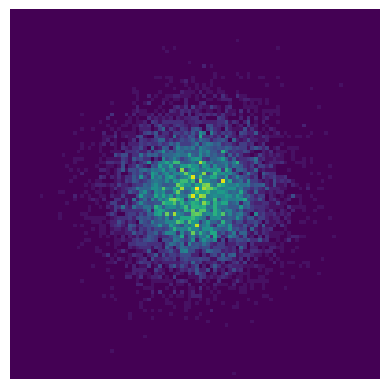

In [10]:
# Plot what we've made
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mass_hist_img.img)
ax.axis(False)
plt.show()
plt.close(fig)

However, stellar particles in SPH simulations are not point sources. In fact we defined the smoothing lengths that describes each stellar particle's SPH kernel above when we made the `Stars`. If we pass `"smoothed"` instead of `"hist"` to `img_type` we can make use of these smoothing lengths and make an image of the stellar distribution correctly smoothed of the SPH kernels.

In [11]:
img_start = time.time()

# Get the image
mass_smooth_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="smoothed",
    pixel_values=stars._current_masses, 
)
    
print("Smoothed image took:", time.time() - img_start)

Smoothed image took: 0.27397584915161133


We also provide helper functions for making plots from the computed image arrays. In the simplest use case the user only has to state the type of image they'd like to plot: `"standard"` for the images we've made here, and `"psf"` for images with PSFs and `"noise"` for images including nosie, both of which we will cover shortly. The user can also optionally state the colormap to use, provide a normalisation range for the image/images and provide a function to scale the pixel values but we will ignore those here.

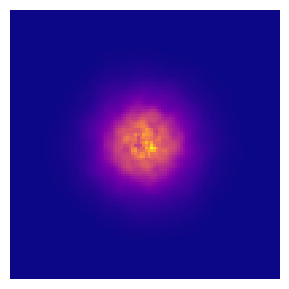

In [12]:
# Plot what we've made
fig, ax = mass_smooth_img.plot_image(img_type="standard", show=True, cmap="plasma")
plt.close(fig)

### Photometric imaging

What we really want is observed photometric images in the filters we defined earlier. Compared to the simple mass map we now need to provide a number of extra arguments: 

- `sed`: The `SED` object we created earlier containing the rest frame and observed SEDs and wavelength/frequency arrays.
- `filters`: The `FilterCollection` we defined earlier with the bands we want images in.
- `rest_frame`: A boolean flag for whether we want the rest frame or observed photometric images. Here we will make observed images.
- `cosmo`: The astropy.cosmology object defining the employed cosmology.

Internally a spectral data cube is made first and stored in the image at `Image.ifu_obj` (the data cube array itself being stored in `Image.ifu_obj.ifu`) which the filter curves are then convolved with to produce the photometric images in each band. This process is significantly more efficient than making images using the photometry of each particle, even when only using 2 filters. 

In [13]:
img_start = time.time()

# Get the image
hist_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="hist",
    sed=sed,
    filters=filters,
    rest_frame=False,
    cosmo=cosmo,
)

# Get the image
smooth_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="smoothed",
    sed=sed,
    filters=filters,
    rest_frame=False,
    cosmo=cosmo,
)

print("Images took:", time.time() - img_start)

Images took: 0.9897150993347168


When making images in multiple bands the image arrays themselves are stored in a dictionary of the form `{f.filter_code: img_array}`. Below we extract this dictionary and plot each of the images we have made.

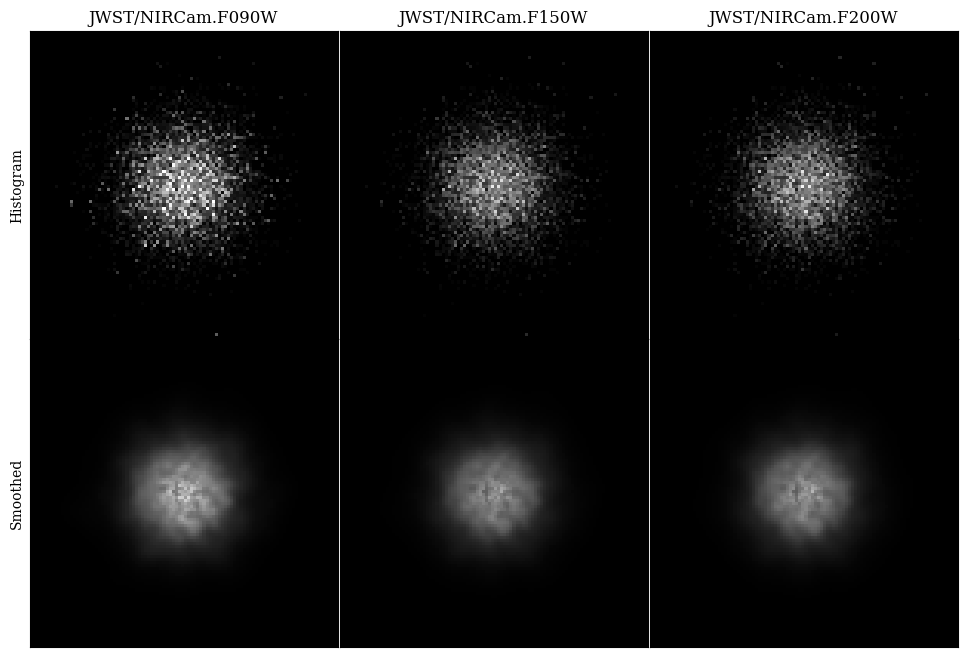

In [14]:
hist_imgs = hist_img.imgs
smooth_imgs = smooth_img.imgs

# Lets set up a simple normalisation across all images
vmax = 0
for img in hist_imgs.values():
    up = np.percentile(img, 99.9)
    if up > vmax:
        vmax = up
for img in smooth_imgs.values():
    up = np.percentile(img, 99.9)
    if up > vmax:
        vmax = up
norm = cm.Normalize(vmin=0, vmax=vmax)
    
# Set up plot
fig = plt.figure(figsize=(4 * len(filters), 4 * 2))
gs = gridspec.GridSpec(2, len(filters), hspace=0.0, wspace=0.0)

# Create top row
axes = []
for i in range(len(filters)):
    axes.append(fig.add_subplot(gs[0, i]))

# Loop over images plotting them
for ax, fcode in zip(axes, filter_codes):
    ax.imshow(hist_imgs[fcode], norm=norm, cmap="Greys_r")
    ax.set_title(fcode)
    ax.tick_params(axis='both', which='both', left=False, 
                   right=False, labelleft=False, labelright=False, 
                   bottom=False, top=False, labelbottom=False, 
                   labeltop=False)

# Set y axis label on left most plot
axes[0].set_ylabel("Histogram")

# Create bottom row
axes = []
for i in range(len(filters)):
    axes.append(fig.add_subplot(gs[1, i]))

# Loop over images plotting them
for ax, fcode in zip(axes, filter_codes):
    ax.imshow(smooth_imgs[fcode], norm=norm, cmap="Greys_r")
    ax.tick_params(axis='both', which='both', left=False, 
                   right=False, labelleft=False, labelright=False, 
                   bottom=False, top=False, labelbottom=False, 
                   labeltop=False)

# Set y axis label on left most plot
axes[0].set_ylabel("Smoothed")

# Plot the image
plt.show()
plt.close(fig)

## Including a Point Spread Function (PSF)

Of course, the smoothed distribution is only part of the story. To properly model observations by a particular observatory we need to take into account the smoothing due to the PSF of the telescope. 

We take the PSFs as arrays stored in a dictionary of the form `{f.filter_code: psf_array}`, where each filter has its own PSF array (optionally a single array can be passed and appliec to all filters). Here we will just create a fake gaussian PSF for all filters but PSFs can be sourced however the user wishes (for Webb we recommend the _webbpsf_ package) as long as a simple numpy array is passed within the psf dictionary for each filter.

We also enable automatic super sampling of the image via the `psf_resample_factor` argument to improve the results of the convolution. The number of pixels along an axis will be increased by this factor prior to the intial image creation, the convolution is then applied at the super resolution and then all images are downsampled back to the native resolution.

Note that a single call to `Galaxy.make_image` computes all types of images needed depending on the passed arguments, there is no need to create the image without the PSF first as we did above. Using the lower level interface each stage can be applied separately (see the images docs). The initial "PSF-less" image will be created at the super sampled resolution and then both `Image.imgs` and the PSF convolved images will be downsampled after convolution to the native pixel resolution. For finer control over resampling the user can use the base Image objects themselves.

In [15]:
# Create a fake PSF for each filter
psf = np.outer(     
    signal.windows.gaussian(50, 3), signal.windows.gaussian(50, 3)
)
psfs = {f: psf for f in filters.filter_codes}

img_start = time.time()

# Get the image
psf_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="smoothed",
    sed=sed,
    filters=filters,
    rest_frame=False,
    cosmo=cosmo,
    psfs=psfs,
    psf_resample_factor=2,
)

print("PSF images made, took:", time.time() - img_start)

PSF images made, took: 3.856666088104248


After convolution the results are stored in a dictionary, `Image.imgs_psf` (or `Image.img_psf` for singular images made from an array). Here we will use the plotting helper function to plot these images with some normalisation.

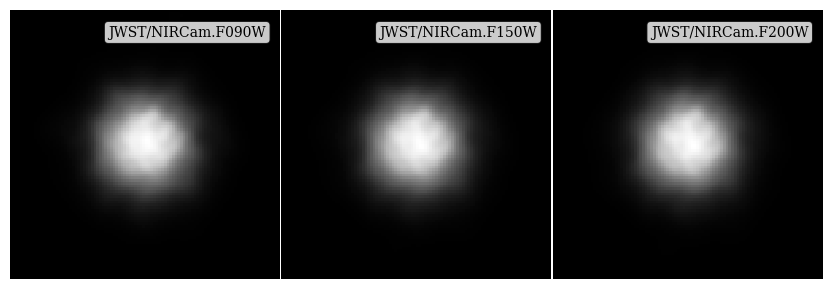

In [16]:
psf_imgs = psf_img.imgs_psf

# Lets set up a simple normalisation across all images
vmax = 0
for img in psf_imgs.values():
    up = np.percentile(img, 99.9)
    if up > vmax:
        vmax = up
    
# Get the plot
fig, ax = psf_img.plot_image(img_type="psf", show=True, vmin=0, vmax=vmax)
plt.close(fig)

## Including noise

The final ingredient for a fully forward modelled synthetic image is a noise field. We enable a couple interfaces to implement these on the images: 
- A simple implementation via the `noises` argument. If this argument is passed to `Galaxy.make_image` then a noise field will be created centred on 0 with this standard deviation for each filer if `noises` is a dictionary. If `noises` is a single value it will be used for all filters.
- A more sophisticated method where the noise is calculated using an aperture, a signal to noise ratio/s (SNR/s), and depths in each filter. The arguments are defined as follows:
    - `aperture`: Either a single value or a dicitonary with a value per filter defining the radius of the aperture in which the noise is defined. This/these values are assumed to be in the image unit system defined by the resolution.
    - `snrs`: Either a single value or a dicitonary with a value per filter defining the signal to noise ratio inside the aperture.
    - `depths`: Either a single value or a dicitonary with a value and unit per filter defining the depth in each filter. Must be defined in the same units as the pixel values (erg / s / Hz for rest frame luminosity, nJy for flux images). There are helper functions in `synthesizer.utils` which enable easy switching between unit systems. 
    
As with the PSF images this can all be handled in a single call to `Galaxy.make_image`. If PSFs have been provided the noise will be applied to the images with a PSF, otherwise the PSF-less images will be used.

Below we demonstrate the the first simple approach using the `noises` argument. Images with noise are stored in a dictionary, `Image.imgs_noise` (or `Image.img_noise` for singular images made from an array). 

Noisy images made, took: 0.9615030288696289


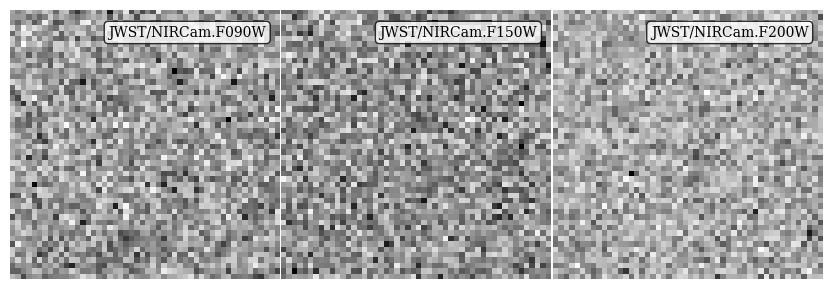

In [17]:
# Redefine image resolution (here we arbitrarily set it to 50 pixels along an axis)
resolution = (width.value / 50) * Mpc

img_start = time.time()

# Get the image
simple_noise_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="smoothed",
    sed=sed,
    filters=filters,
    rest_frame=False,
    cosmo=cosmo,
    psfs=psfs,
    psf_resample_factor=2,
    noises=30 * nJy,
)

print("Noisy images made, took:", time.time() - img_start)

simple_noise_imgs = simple_noise_img.imgs_noise

# Lets set up a simple normalisation across all images
vmax = 0
for img in simple_noise_imgs.values():
    up = np.percentile(img, 99.9)
    if up > vmax:
        vmax = up

# Get the plot
fig, ax = simple_noise_img.plot_image(img_type="noise", show=True, vmin=0, vmax=vmax)
plt.close(fig)

And here we define a toy set of `depths` with a fixed SNR and aperture size.

Smoothed images made, took: 0.9073481559753418
[(50, 50), (50, 50), (50, 50)]


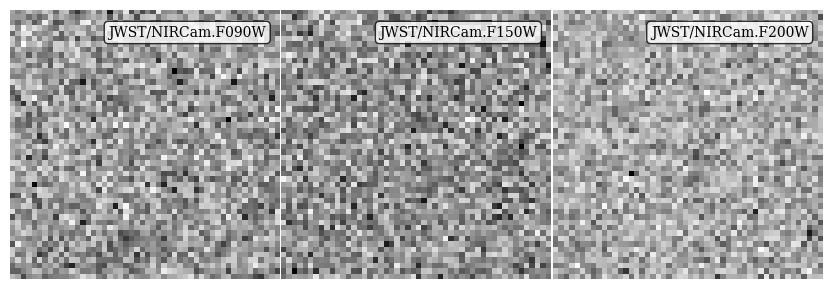

In [18]:
# Redefine image resolution (here we arbitrarily set it to 50 pixels along an axis)
resolution = (width.value / 50) * Mpc

# Create the dictionary of depths
depths = {f.filter_code: 100 * nJy for f in filters}

img_start = time.time()

# Get the image
noise_img = galaxy.make_images(
    resolution,
    fov=width,
    img_type="smoothed",
    sed=sed,
    filters=filters,
    rest_frame=False,
    cosmo=cosmo,
    psfs=psfs,
    psf_resample_factor=2,
    depths=depths,
    snrs=5,
    aperture=0.2,
)

print("Smoothed images made, took:", time.time() - img_start)

noise_imgs = noise_img.imgs_noise
print([noise_imgs[f.filter_code].shape for f in filters])
# Lets set up a simple normalisation across all images
vmax = 0
vmin = np.inf
for img in noise_imgs.values():
    up = np.percentile(img, 99.9)
    low = -np.percentile(img, 32)
    if up > vmax:
        vmax = up
    if low < vmin:
        vmin = low
        
# Get the plot
fig, ax = simple_noise_img.plot_image(img_type="noise", show=True, vmin=vmin, vmax=vmax)
plt.close(fig)

Finally we can use the RGB image method on the `Image` object to make quick RGB images by simply providing a dictionary detailing which filters we want in which bands, the type of image we want (once again `"standard"`, `"psf"`, or `"noise"`) and optional weights which we will ignore here.

Scaling to: 4.839517657204117 -> 30.552140287418393
(50, 50, 3)


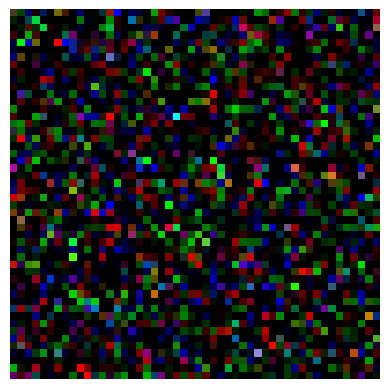

In [19]:
# Create the rgb image from the psf image above example using our 3 filters
rgb_img = noise_img.make_rgb_image(
    rgb_filters={"R": ["JWST/NIRCam.F200W",],
                 "G": ["JWST/NIRCam.F150W",],
                 "B": ["JWST/NIRCam.F090W",]},
    img_type="noise",
)

# Set up minima and maxima
vmin = -np.percentile(rgb_img, 32)
vmax = np.percentile(rgb_img, 99.9)
norm = cm.Normalize(vmin=vmin, vmax=vmax, clip=True)
print("Scaling to:", vmin, "->", vmax)

# Normalise the image.
rgb_img = norm(rgb_img)

print(rgb_img.shape)

# Plot the image
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(rgb_img, origin="lower", interpolation="nearest")
ax.axis("off")
plt.show()
plt.close(fig)